## Extract data from downloaded LIS files,convert it to dataframe, spatially filter and save as CSV

In [1]:
import sys
import os
import glob
from netCDF4 import Dataset, num2date
import numpy as np
import csv
import pandas as pd
from datetime import datetime
import timeit

In [2]:
##Please add your own path where all your iss_lis files are saved in pc

file_path = 'C:/Users/Aditya/Desktop/Research2022_Walker/iss_no2_test/'
dataDir = os.path.join(file_path, '') 

In [3]:
%%time
## Search and locate all files starting with 'ISS_LIS_' and ending with extension '.nc'

raw_files = glob.glob(dataDir+'ISS_LIS_*.nc')
files = [os.path.normpath(i) for i in raw_files] 
files

CPU times: total: 0 ns
Wall time: 0 ns


['C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.1_20220716_011826_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.1_20220716_025116_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.1_20220716_042407_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.1_20220716_055658_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.1_20220716_072948_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.2_20220716_011826_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.2_20220716_025116_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.2_20220716_042407_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Walker\\iss_no2_test\\ISS_LIS_SC_V2.2_20220716_055658_NQC.nc',
 'C:\\Users\\Aditya\\Desktop\\Research2022_Wal

In [4]:
%%time

orbit_start = []
orbit_end = []

for i in files:
    datafile = Dataset(i,'r')
    
    start_value = datafile.variables['orbit_summary_TAI93_start'][:].data.tolist()
    start_value_units = datafile.variables['orbit_summary_TAI93_start']
    end_value = datafile.variables['orbit_summary_TAI93_end'][:].data.tolist()
    end_value_units = datafile.variables['orbit_summary_TAI93_end']
    orbit_start.append(start_value)
    orbit_end.append(end_value)
        
    start_dates = num2date(orbit_start[:], start_value_units.units)
    stop_dates = num2date(orbit_end[:], end_value_units.units)

    begin_date_value = min(start_dates)
    end_date_value = max(stop_dates)

    #Create text and numerical dates to use in file names and plot title
    begin_date = begin_date_value.strftime("%B %d, %Y")
    end_date = end_date_value.strftime("%B %d, %Y")
    begin_int = begin_date_value.strftime("%Y%m%d")
    end_int = end_date_value.strftime("%Y%m%d")
    
    #Create CSV file and destination
    csvfile = os.path.join(dataDir, 'isslis_flashloc_'+ begin_int + '_' + end_int +'.csv')
    
csvfile

CPU times: total: 312 ms
Wall time: 315 ms


'C:/Users/Aditya/Desktop/Research2022_Walker/iss_no2_test/isslis_flashloc_20220716_20220716.csv'

In [5]:
%%time
## Extract data for each variables of interest from multiple files and concat them together  

flash_lat = np.array([]) ##latitude
flash_lon = np.array([]) ##longitude
flash_radiance = np.array([]) ##flash magnitude
flash_time_secs = np.array([]) ##flash occurance

for i in files:
    datafile = Dataset(i)
    
    flash_lat = np.concatenate([flash_lat,datafile.variables['lightning_flash_lat'][:]]) #add to array
    flash_lon = np.concatenate([flash_lon,datafile.variables['lightning_flash_lon'][:]]) 
    flash_radiance = np.concatenate([flash_radiance,datafile.variables['lightning_flash_radiance'][:]])
    flash_time_secs = np.concatenate([flash_time_secs,datafile.variables['lightning_flash_TAI93_time'][:]])

CPU times: total: 266 ms
Wall time: 270 ms


In [6]:
%%time
## Convert seconds time (starting from 1993-01-01) to Datetime(local time)  

flash_time_units = datafile.variables['lightning_flash_TAI93_time']

flash_time = num2date(flash_time_secs[:], flash_time_units.units)
    
flash_time_loc = [d.strftime('%Y-%m-%d %H:%M:%S %z') for d in flash_time]

flash_time
flash_time_units.units

CPU times: total: 141 ms
Wall time: 148 ms


'seconds since 1993-01-01 00:00:00.000'

In [7]:
%%time
## Convert all variables in arrays to pandas DataFrame
iss_pd = pd.DataFrame(data=zip(flash_lat,flash_lon,flash_radiance,flash_time_loc),columns=['flash_lat','flash_lon','flash_radiance','flash_time_loc'])#.set_index('srno')
iss_pd

CPU times: total: 46.9 ms
Wall time: 40 ms


,flash_lat,flash_lon,flash_radiance,flash_time_loc
0,-18.592598,-141.723007,815680.0,2022-07-16 01:34:54 -0400
1,-15.787505,-137.807007,45360.0,2022-07-16 01:35:58 -0400
2,-15.797224,-137.795166,62357.0,2022-07-16 01:36:05 -0400
3,-15.779601,-137.771164,239794.0,2022-07-16 01:36:11 -0400
4,-15.778400,-137.775360,433388.0,2022-07-16 01:36:28 -0400
...,...,...,...,...
3118,-16.263081,-40.404400,20184.0,2022-07-16 08:44:22 -0400
3119,-16.302338,-40.363708,12530.0,2022-07-16 08:44:22 -0400
3120,-15.012276,-38.550610,5536.0,2022-07-16 08:44:29 -0400
3121,-15.065495,-38.683620,25876.0,2022-07-16 08:45:21 -0400


**Filter data Spatially based on 'REGION OF INTEREST' as represented by hashed portion in bounding rectangle**                   ***(Focus is curretly on Canada region)*** 

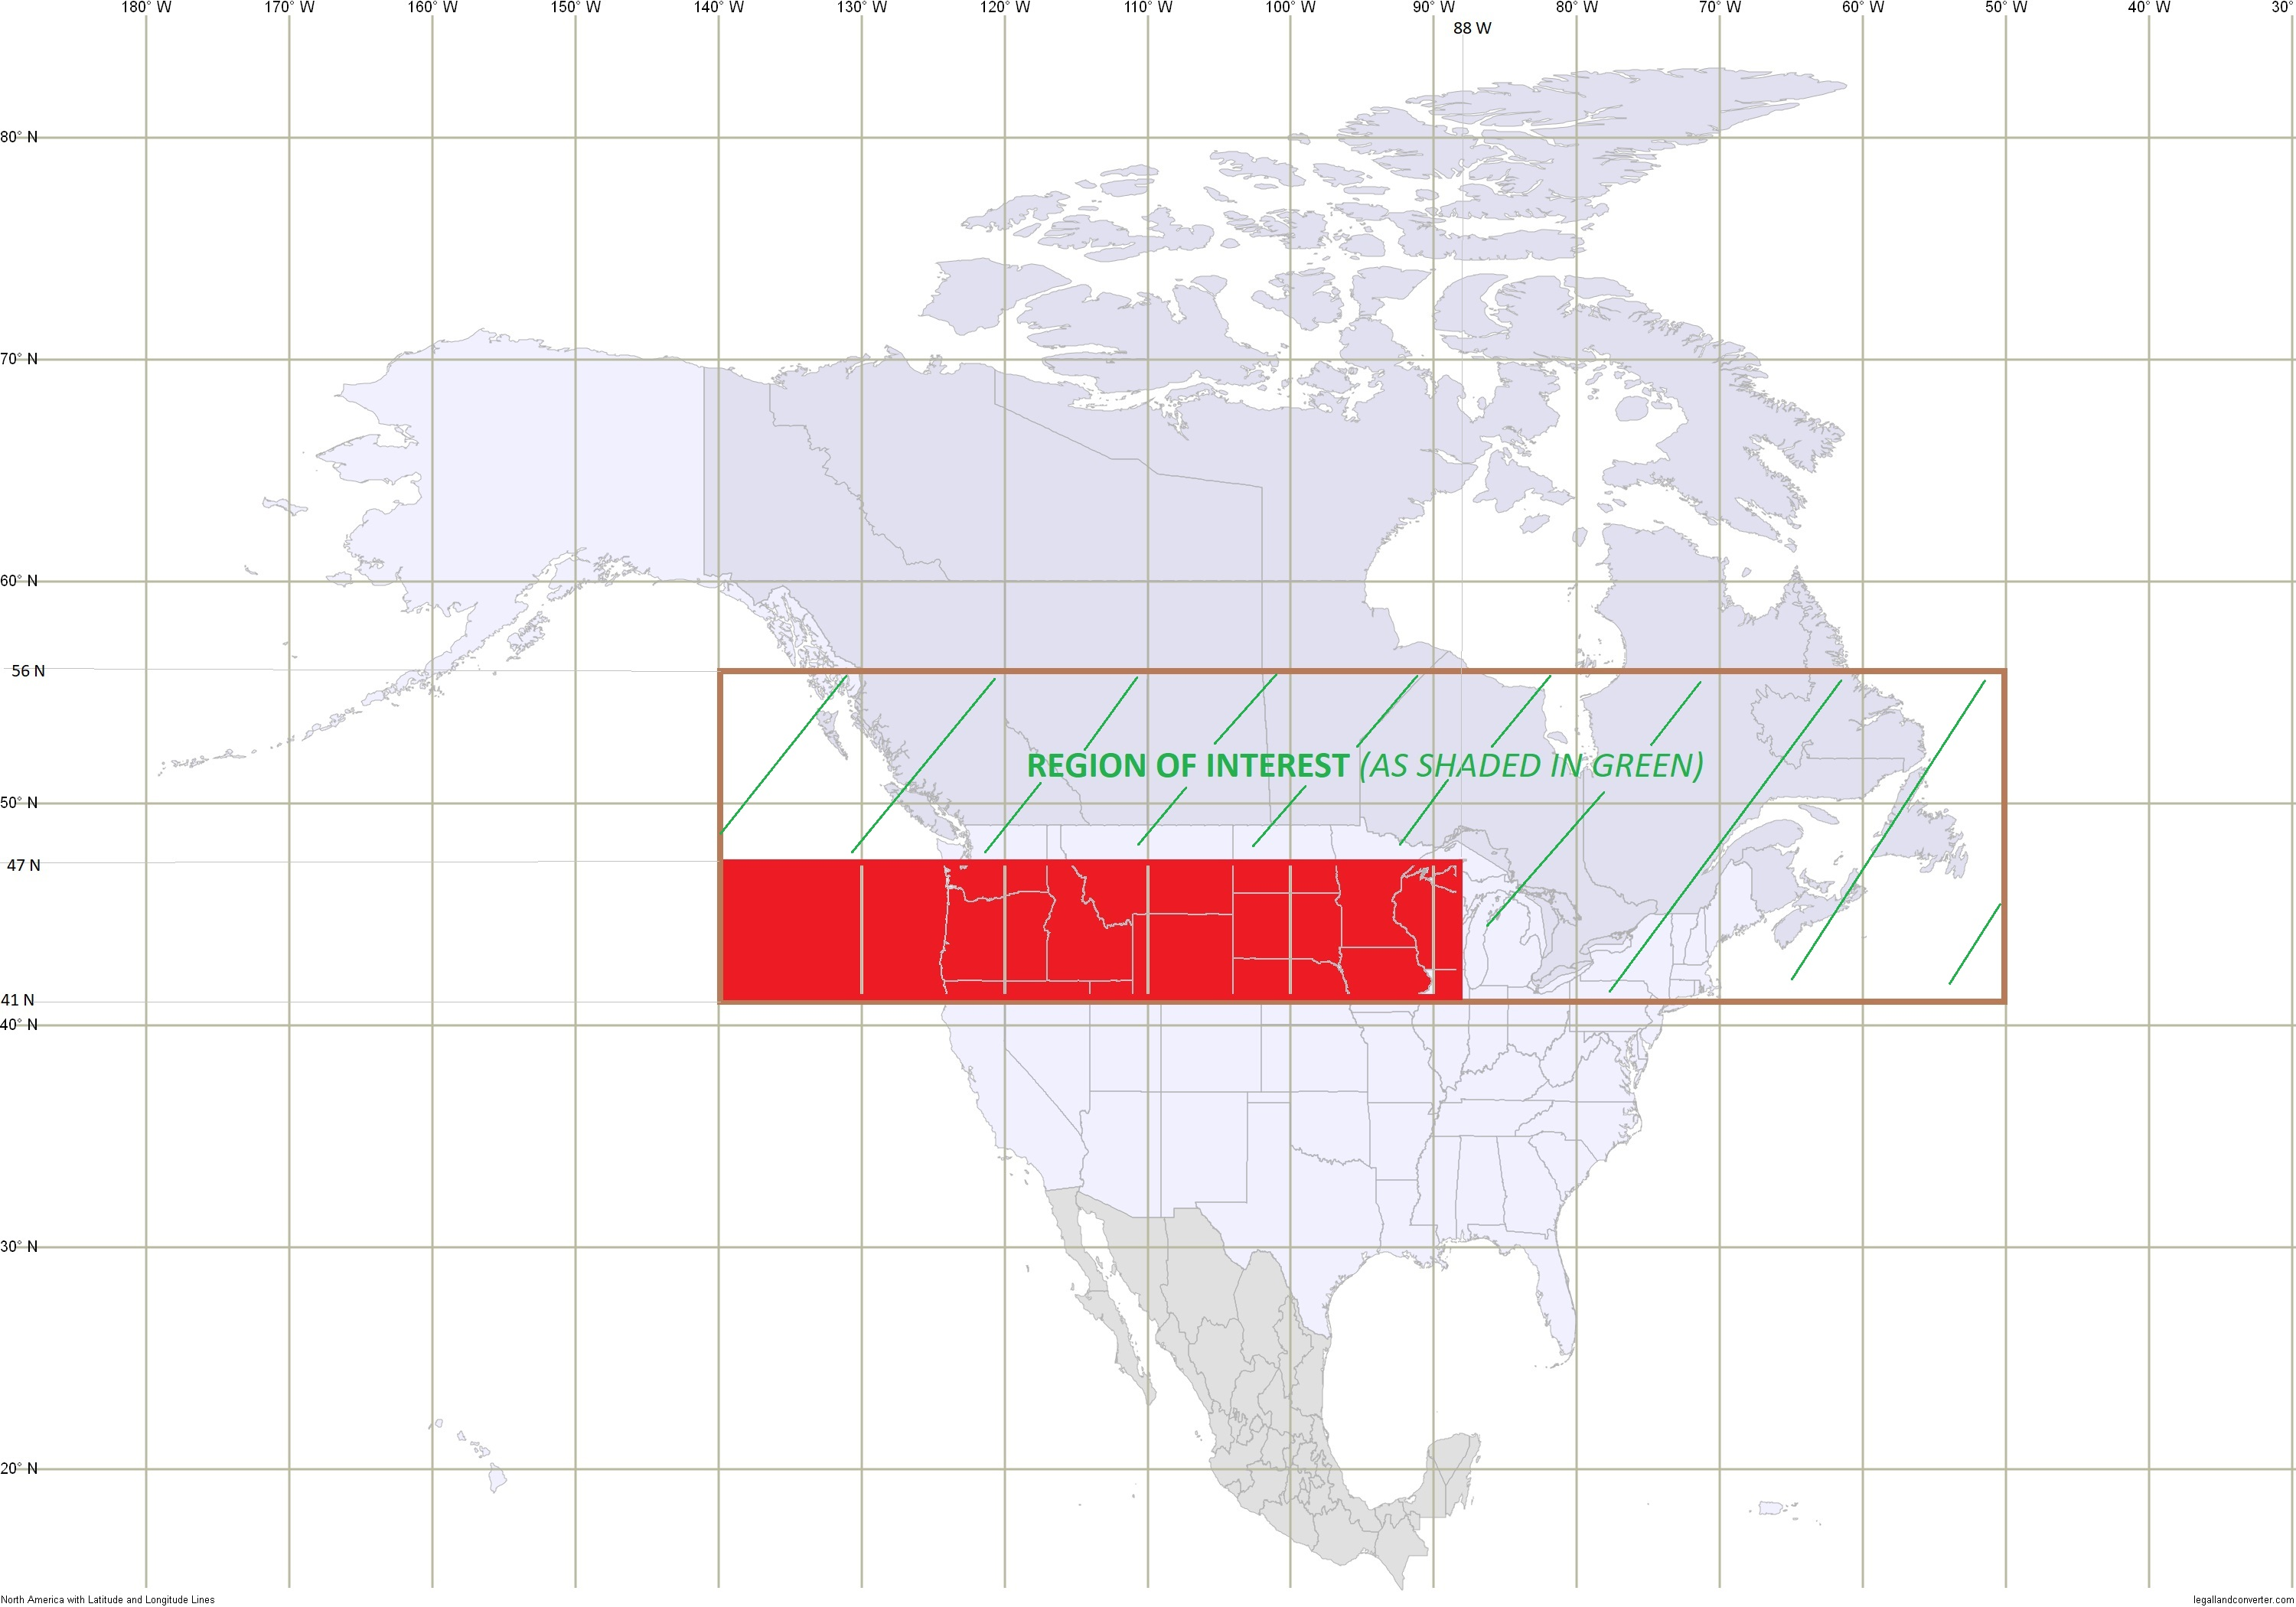

In [8]:
%%time
##Primary bounding rectangle (brown colour sides) : Canada boundry west_lon=140, east_lon=50, north_lat=56, south_lat=35) 
iss_pd_sr = iss_pd.query('-140 <= flash_lon <= -50 and 41 < flash_lat <= 56')
iss_pd_sr

CPU times: total: 0 ns
Wall time: 20.3 ms


,flash_lat,flash_lon,flash_radiance,flash_time_loc
262,44.115730,-110.112030,977240.0,2022-07-16 03:29:49 -0400
263,44.137966,-110.084808,327419.0,2022-07-16 03:30:44 -0400
266,43.976608,-110.578941,25559.0,2022-07-16 03:29:40 -0400
267,43.977440,-110.475632,411665.0,2022-07-16 03:29:41 -0400
268,43.907143,-110.758842,322543.0,2022-07-16 03:29:55 -0400
...,...,...,...,...
3032,46.244812,-101.271820,824518.0,2022-07-16 08:22:47 -0400
3033,46.234650,-101.235802,17795.0,2022-07-16 08:23:43 -0400
3034,48.330528,-100.968330,320281.0,2022-07-16 08:22:40 -0400
3035,48.427315,-100.902489,27739.0,2022-07-16 08:22:40 -0400


In [9]:
%%time
## Select unwanted bounding rectangle (-140,41,-88,47) as highhlighted in solid red colour (lying completely inside USA region)
iss_pd_sr1 = iss_pd_sr.query('-140 < flash_lon <= -88 and 41 <= flash_lat <= 47')
iss_pd_sr1

CPU times: total: 46.9 ms
Wall time: 25 ms


,flash_lat,flash_lon,flash_radiance,flash_time_loc
262,44.115730,-110.112030,977240.0,2022-07-16 03:29:49 -0400
263,44.137966,-110.084808,327419.0,2022-07-16 03:30:44 -0400
266,43.976608,-110.578941,25559.0,2022-07-16 03:29:40 -0400
267,43.977440,-110.475632,411665.0,2022-07-16 03:29:41 -0400
268,43.907143,-110.758842,322543.0,2022-07-16 03:29:55 -0400
...,...,...,...,...
1943,46.988869,-104.194321,114480.0,2022-07-16 03:31:32 -0400
1944,43.837769,-101.077774,77459.0,2022-07-16 03:31:49 -0400
3031,46.300571,-101.330452,310392.0,2022-07-16 08:22:19 -0400
3032,46.244812,-101.271820,824518.0,2022-07-16 08:22:47 -0400


In [10]:
%%time
## Data from green hashed 'REGION OF INTEREST' would be

## obtained by deleting the unwanted bounding 'red coloured' rectangle from the primary bounding rectangle
iss_pd_sr2 = pd.concat([iss_pd_sr,iss_pd_sr1]).drop_duplicates(keep=False)
iss_pd_sr2

CPU times: total: 15.6 ms
Wall time: 17.4 ms


,flash_lat,flash_lon,flash_radiance,flash_time_loc
383,52.285534,-83.065956,253300.0,2022-07-16 03:34:39 -0400
384,52.675556,-78.900047,3913977.0,2022-07-16 03:35:48 -0400
630,51.050793,-104.763046,13620.0,2022-07-16 05:07:26 -0400
631,51.144081,-104.693893,335410.0,2022-07-16 05:07:29 -0400
632,51.175934,-104.811951,145902.0,2022-07-16 05:07:31 -0400
...,...,...,...,...
3029,47.236641,-101.432999,854450.0,2022-07-16 08:22:27 -0400
3030,47.318756,-101.372711,320838.0,2022-07-16 08:23:19 -0400
3034,48.330528,-100.968330,320281.0,2022-07-16 08:22:40 -0400
3035,48.427315,-100.902489,27739.0,2022-07-16 08:22:40 -0400


In [11]:
%%time
## Lastly save all data from dataframe into a single CSV file 

###PLEASE UNCOMMENT THE BELOW TO LINE TO TO DF AS SAVE CSV
#with open(csvfile, 'w', newline='') as myfile:
 #   iss_pd_sr2.to_csv(csvfile,index=False)

CPU times: total: 0 ns
Wall time: 0 ns


.

**In a nutshell,
We were able to extarct data from multiple netCDF4 files for 4 specific variables: flash_lat, flash_lon,flash_radiance and flash_time out of 120 variables,
Later on ,the data was filtered spatially based on region of interest: number of rows dropped from 81355 rows to 22437 rows   (approximately about 70% REDUCTION in no. of rows)
Finally, the sorted data was saved in CSV format**

In [12]:
## Data from all orbits (-180W to 0W)
iss_pd.shape

(3123, 4)

In [13]:
## Primary rectangle bound 
iss_pd_sr.shape

(1928, 4)

In [14]:
## USA data removed by reactangle bound(-140,41,-88,47)
iss_pd_sr1.shape

(245, 4)

In [15]:
## Final Canada coordinates
iss_pd_sr2.shape

(1683, 4)

***THE CODE ENDs***

## Issues yet to be addressed

**All new ideas to execute above code short and more efficiently are always welcomed and Thank you very much for contributing your precious time here! :)**